Import


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras

In [ ]:
dataset_name = 'cifar10'
ds, info = tfds.load(name=dataset_name, split=['train'], with_info=True)
ds = ds[0]
num_examples = info.splits['train'].num_examples
NUM_CLASSES = 10

In [4]:
train_split = 0.4
num_train = int(train_split * num_examples)
ds_train = ds.take(num_train)
ds_train_min = ds.skip(num_train)

DATASET_NUM_TRAIN_EXAMPLES = num_train
DATASET_NUM_TRAIN_EXAMPLES

20000

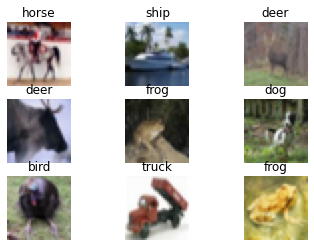

In [79]:
# check the dataset, cool

def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[0]

label_info = info.features["label"]
for i, (feature_data) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(feature_data['image'].numpy().astype("uint8"))
    plt.title("{}".format(format_label(feature_data['label'])))
    plt.axis("off")

# Building Model for Upstream

In BiT paper they state, the Upstream architecture is vanilla Resnet-V2 [sectoin 3.3], but they change the BatchNorm to group norm and add weight standarization.

but since in their analysis [section 4.3], on choosing the GroupNorm insteat of batch norm is due to train a large dataset on model only feasible if using a many hardware, and they state, BN become worse when the number of images on each accelerator is too low. since i will not retrain the upstream model, i will keep the architecture as it is

In [14]:
# Since they also test on ResNet50, i will use wellKnown vanilla ResNet50-v2 as my upstream model.
# it will take [none, none, 3] input images and output 2048 (after average pooling) feature as output (without head from imagenet model)

base_model_2nd = keras.applications.ResNet50V2(include_top=False, weights='imagenet', pooling='avg',  input_shape=(None, None, 3))
base_model_2nd.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

# Building Downstream

They state the downstream model, they state 
"To attain a low per-task adaptation cost, we do
not perform any hyperparameter sweeps downstream. Instead, we present BiTHyperRule, a heuristic to determine all hyperparameters for fine-tuning. Most
hyperparameters are fixed across all datasets, but schedule, resolution, and usage
of MixUp depend on the tasks image resolution and training set size."

so i assume the head will only a single dense layer to adapt with the new dataset, and the hyper parameter will be the schedule, resolution, and training size. tobe honest i did not implement the MixUp.

In [7]:
# first of all let freze the baseline Resnet50 Model
base_model_2nd.trainable = False

''' since i will use CIFAR-10 as a finetuning the downstream 
    and Cifar dataset contain of image with 32 x 32 
    based on their hyper parameter rule
    we need to resize the dataset to 160 x 160 and crop to 128 [1 hyper param]
    so i will create the input layer as 128 x 128 x 3 
''' 
inputs = keras.Input(shape=(128, 128, 3))

''' and since i will use a pretrain model from keras.application, 
    i should also add their preprocessing layer,
    this preprocessing layer will only normalize the input RGB [0 to 255]
    into normalize value [-1 to 1], and convert to bgr, 
    and will zerocenter respectively to imagenetDataset
    https://keras.io/api/applications/resnet/
'''
x = keras.applications.resnet_v2.preprocess_input(inputs)

# then add connection between the input layer and baseline model
x = base_model_2nd(x, training=False)


# lastly, create a new head with the new output classes number, in this case i will use 10 for cifar10
outputs = tf.keras.layers.Dense(10, kernel_initializer='zeros')(x)
model_new = keras.Model(inputs, outputs)

# Fine Tunning the Downstream HyperRule

In [8]:
# They resize the image to 160 if the size of images below 96 x 96
RESIZE_TO = 160

# and then take a random crop of 128 × 128 pixels
CROP_TO = 128

# for the schedule length, they use three different number
# for this case, i will use the small one (if the dataset < 20k labelled data)
SCHEDULE_LENGTH = 500

# During fine-tuning, we decay the learning rate by a factor of
# 10 at 30%, 60% and 90% of the training step
SCHEDULE_BOUNDARIES = [200, 300, 400]

In [9]:
# Preprocessing helper functions

# Create data pipelines for training and testing:
BATCH_SIZE = 512
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE
STEPS_PER_EPOCH = 10

def cast_to_tuple(features):
  return (features['image'], features['label'])
  

def preprocess_train(features):
  # They state to apply random Horizontal flip,
  features['image'] = tf.image.random_flip_left_right(features['image'])

  # resize the dataset to 160
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])

  # take a random crop at 128
  features['image'] = tf.image.random_crop(features['image'], [CROP_TO, CROP_TO, 3])
  return features

def preprocess_test(features):
  # for the validation dataset, i will only resize to 128
  features['image'] = tf.image.resize(features['image'], [CROP_TO, CROP_TO])
  return features

pipeline_train = (ds_train
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  # repeat dataset_size / num_steps
                  .map(preprocess_train)
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)  # for keras model.fit
                  .prefetch(2))

pipeline_test = (ds_train_min
                  .map(preprocess_test)
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(2))

In [10]:
# Downstream initial learning rate 0.003
lr = 0.003

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES (30%, 60%, 90%).
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])

# For all task they says they use SGD with 0.9 momentum
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [11]:
# compile the model, there should be 20490 trainable param
# since we freze all of the upstream param
model_new.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 128, 128, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
# train the model with the new head, 
# to be honest i didnt rerun this task
# since i just cleaning everything, and i dont want to run 50 epocs again.
epochs= int(SCHEDULE_LENGTH / STEPS_PER_EPOCH)
history = model_new.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs= epochs, 
    validation_data=pipeline_test
)

Epoch 1/50
10/10 [==============================] - 46s 4s/step - loss: 1.5925 - accuracy: 0.5824 - val_loss: 0.8796 - val_accuracy: 0.7316
Epoch 2/50
10/10 [==============================] - 31s 3s/step - loss: 0.8190 - accuracy: 0.7199 - val_loss: 0.6893 - val_accuracy: 0.7717
Epoch 3/50
10/10 [==============================] - 31s 3s/step - loss: 0.7581 - accuracy: 0.7531 - val_loss: 0.6336 - val_accuracy: 0.7860
Epoch 4/50
10/10 [==============================] - 31s 3s/step - loss: 0.7144 - accuracy: 0.7561 - val_loss: 0.6121 - val_accuracy: 0.7945
Epoch 5/50
10/10 [==============================] - 31s 3s/step - loss: 0.6315 - accuracy: 0.7881 - val_loss: 0.5896 - val_accuracy: 0.8036
Epoch 6/50
10/10 [==============================] - 31s 3s/step - loss: 0.6470 - accuracy: 0.7844 - val_loss: 0.5769 - val_accuracy: 0.8063
Epoch 7/50
10/10 [==============================] - 31s 3s/step - loss: 0.6226 - accuracy: 0.7848 - val_loss: 0.5602 - val_accuracy: 0.8140
Epoch 8/50
10/10 [==

In [14]:
model_new.save('mdl')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: mdl/assets


INFO:tensorflow:Assets written to: mdl/assets


# For demonstration purpose i will re run 10 epochs of this project

In [ ]:
epochs= 10
history = model_new.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs= epochs, 
    validation_data=pipeline_test
)

# Testing on bigger architech

In [13]:
base_model_3nd = keras.applications.ResNet152V2(include_top=False, weights='imagenet', pooling='avg',  input_shape=(None, None, 3))
base_model_3nd.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [16]:
# first of all let freze the baseline Resnet50 Model
base_model_3nd.trainable = False

inputs = keras.Input(shape=(128, 128, 3))
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = base_model_3nd(x, training=False)
outputs = tf.keras.layers.Dense(10, kernel_initializer='zeros')(x)
model_new_3nd = keras.Model(inputs, outputs)

In [17]:
# compile the model, there should be 20490 trainable param
# since we freze all of the upstream param
model_new_3nd.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

model_new_3nd.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 128, 128, 3)       0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 2048)              58331648  
_________________________________________________________________
dense_2 (Dense)              (None, 10)                20490     
Total params: 58,352,138
Trainable params: 20,490
Non-trainable params: 58,331,648
_________________________________________________________________


In [19]:
# train the model with the new head, 
# to be honest i didnt rerun this task
# since i just cleaning everything, and i dont want to run 50 epocs again.
epochs= 10 # to fasten the test
history = model_new_3nd.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs= epochs, 
    validation_data=pipeline_test
)

Epoch 1/10
10/10 [==============================] - 203s 17s/step - loss: 1.6696 - accuracy: 0.5602 - val_loss: 0.9386 - val_accuracy: 0.7441
Epoch 2/10
10/10 [==============================] - 148s 16s/step - loss: 0.8677 - accuracy: 0.7316 - val_loss: 0.7325 - val_accuracy: 0.7568
Epoch 3/10
10/10 [==============================] - 148s 16s/step - loss: 0.7594 - accuracy: 0.7457 - val_loss: 0.6541 - val_accuracy: 0.7891
Epoch 4/10
10/10 [==============================] - 148s 16s/step - loss: 0.7468 - accuracy: 0.7523 - val_loss: 0.6230 - val_accuracy: 0.7971
Epoch 5/10
10/10 [==============================] - 148s 16s/step - loss: 0.6825 - accuracy: 0.7738 - val_loss: 0.6021 - val_accuracy: 0.8043
Epoch 6/10
10/10 [==============================] - 148s 16s/step - loss: 0.6417 - accuracy: 0.7885 - val_loss: 0.5857 - val_accuracy: 0.8082
Epoch 7/10
10/10 [==============================] - 148s 16s/step - loss: 0.6288 - accuracy: 0.7937 - val_loss: 0.5807 - val_accuracy: 0.8098
Epoch 

(-0.5, 31.5, 31.5, -0.5)

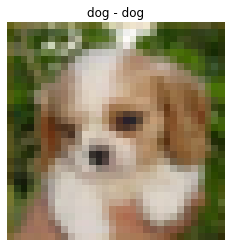

In [100]:
ax = ds_train_min.shuffle(100)
for feature in ax.take(1):
  image = tf.image.resize(feature['image'], [128, 128])
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  res = model_new_3nd.predict(img_reshaped)
  idx = np.argmax(res)

plt.imshow(feature['image'].numpy().astype("uint8"))
plt.title("{} - {}".format(format_label(feature['label']),  info.features["label"].int2str(idx)))
plt.axis("off")